<a href="https://colab.research.google.com/github/proshanta000/langgraph_l/blob/main/langgraph_rag_chatbot_with_astradb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
!pip install -U \
    langchain \
    langgraph \
    cassio \
    langchain_community \
    langchain_groq \
    langchainhub \
    tiktoken \
    langchain_huggingface \
    wikipedia

# langchain: Core library for building LLM applications.
# langgraph: Library for building stateful, multi-actor applications with LLMs, especially for agent graphs.
# cassio: Integration with DataStax Astra DB (Cassandra-as-a-Service) for vector store and memory.
# langchain_community: Provides various integrations for Langchain, including document loaders and utilities.
# langchain_groq: Enables use of Groq LLMs within Langchain framework.
# langchainhub: Repository for Langchain prompts, chains, and agents.
# tiktoken: Used for token counting, often by LLMs for managing context window.
# langchain_huggingface: Provides integrations for HuggingFace models, including embeddings.
# wikipedia: Tool for searching information on Wikipedia, used by agents for external knowledge.

In [151]:
import os # Used for interacting with the operating system, though not directly used for environment variables in this specific Colab context.
import cassio # The client library for DataStax Astra DB, providing utilities for connecting and interacting with the database.
from google.colab import userdata # Colab utility to securely retrieve API keys and other sensitive data stored by the user.
from langchain_groq import ChatGroq # Imports the ChatGroq class for integrating Groq's LLMs into Langchain applications.

# groq api connection
groq_api_key = userdata.get('GROQ_API_KEY') # Retrieves the Groq API key securely from Colab's user data secrets.
langsmith = userdata.get('LANGSMITH_API_KEY') # Retrieves the Langsmith API key for tracing and monitoring Langchain applications (if enabled).

# connection of the Astra DB
ASTRA_DB_APPLICATION_TOKEN=userdata.get('ASTRA_DB_KEY') # Retrieves the Astra DB application token for authentication.
ASTRA_DB_ID=userdata.get('ASTRA_DB_ID') # Retrieves the Astra DB database ID.

cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID) # Initializes the Cassio library with the retrieved Astra DB credentials, establishing a connection to the database.

In [152]:
## Build Index
from langchain_text_splitters import RecursiveCharacterTextSplitter # Imports the text splitter for breaking down large texts into smaller, manageable chunks.
from langchain_community.document_loaders import WebBaseLoader # Imports the document loader for fetching content from web pages.

# Doc to index
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
] # List of URLs from which to load documents. These will form the knowledge base for the vector store.


## Load the url
docs = [WebBaseLoader(url).load() for url in urls] # Loads documents from each URL using WebBaseLoader. Each URL's content is fetched.
doc_list=[item for sublist in docs for item in sublist] # Flattens the list of lists of documents into a single list of documents.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 500, # Defines the maximum size of each text chunk in tokens.
    chunk_overlap   = 0, # Specifies the number of tokens to overlap between consecutive chunks. (Here set to 0).
)
docs_split=text_splitter.split_documents(doc_list) # Splits the loaded documents into smaller, appropriately sized chunks, preparing them for embedding and storage in the vector store.

In [153]:
docs_split # This line displays the first few processed document chunks after loading and splitting, verifying the output structure and content.

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [154]:
from langchain_huggingface import HuggingFaceEmbeddings # Imports the class for generating embeddings using Hugging Face models.
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2") # Initializes the embedding model. This model converts text into numerical vector representations, which are crucial for semantic search and storing in a vector database. 'all-MiniLM-L6-v2' is a popular and efficient sentence transformer model.

In [155]:
from cassandra.cluster import Session # Imports Session, which is typically used for direct Cassandra client interaction, though in this Langchain context, CassIO handles the session management internally.
from langchain_community.vectorstores.cassandra import Cassandra # Imports the Cassandra vector store integration for Langchain.

astra_vector_store=Cassandra(
    embedding=embeddings, # Configures the vector store to use the previously initialized HuggingFace embedding model for generating vector representations.
    table_name="qa_mini_demo", # Specifies the name of the table in Astra DB where the document chunks and their embeddings will be stored.
    session=None, # Indicates that the Cassandra session will be managed by the prior cassio.init() call.
    keyspace=None # Indicates that the keyspace will be managed by the prior cassio.init() call.
)

In [156]:
astra_vector_store.add_documents(docs_split) # Indexes the split document chunks and their embeddings into the Astra DB vector store for retrieval.
print("Inserted %i headlines." % len(docs_split)) # Prints a confirmation message indicating the total number of document chunks successfully inserted into the vector store.

Inserted 88 headlines.


In [157]:
# Call as_retriever() on the original, correctly typed object
astra_vecto_retriever = astra_vector_store.as_retriever(k=1) # Initializes a retriever from the Astra vector store, configured to return the top 1 most relevant document for a given query.

In [158]:
astra_vecto_retriever.invoke("what is agent?") # Invokes the retriever with a sample query to demonstrate its functionality. This call retrieves the most relevant document chunks (based on k=1 in the retriever configuration) from the Astra DB vector store that semantically match the query, showcasing the initial retrieval capability.

[Document(id='ddf2c857128f4691a0d96e8484cb8ddc', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [159]:
## Langgraph application
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [160]:
# Data model
class RouteQuery(BaseModel):
  """Route a user query to the most relevent datasource."""
  datasource: Literal["vectorstore", "wikipedia_search"] = Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore."
  )

In [161]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.3-70b-versatile")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7827c63985f0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7827c63996a0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [162]:
structured_llm = llm.with_structured_output(RouteQuery)
structured_llm

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7827c63985f0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7827c63996a0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'RouteQuery', 'description': 'Route a user query to the most relevent datasource.', 'parameters': {'properties': {'datasource': {'description': 'Given a user question choose to route it to wikipedia or a vectorstore.', 'enum': ['vectorstore', 'wikipedia_search'], 'type': 'string'}}, 'required': ['datasource'], 'type': 'object'}}}], 'ls_structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'RouteQuery', 'description': 'Route a user query to the most relevent datasource.', 'parameters': {'properties': {'datasource': {'description': 'Given a user question choose to route it 

In [163]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for question on those topics. Otherwise, use wiki-search."""

route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}"),
])

question_router = route_prompt | structured_llm

In [164]:
print(question_router.invoke({"question": "what is agent?"}))

datasource='vectorstore'


In [165]:
print(question_router.invoke({"question": "who is j k rowling?"}))

datasource='wikipedia_search'


In [166]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.tools import tool
from pydantic import BaseModel, Field

# Define input schemas for the tools
class WikipediaInput(BaseModel):
  query: str = Field(description="The search query for wikipwdia")

# Create tools using the @tool decorator.
# Instantiate API wrappers inside the function to avoid serialization issues
@tool("wikipedia_search", args_schema=WikipediaInput)
def wikipedia_search(query: str) -> str:
  """Search Wikipedia for given query and return the summery."""
  # Instantiate the wrapper each time the tool is called
  _wikipedia_api_wrapper_instance = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
  return _wikipedia_api_wrapper_instance.run(query)

tools = [wikipedia_search]

In [167]:
# Test Wikipedia tool
tools[0].invoke("who is J. K. Rowling")

'Page: Political views of J. K. Rowling\nSummary: The British author J. K. Rowling, writer of Harry Potter and other Wizarding World works, has garnered attention for her support of the Labour Party under Gordon Brown and her criticism of the party under Jeremy Corbyn and Keir Starmer, as well as her '

In [168]:
## AI agents  using langgraph
from typing import List # Imports the List type hint for type annotations.

from typing_extensions import TypedDict # Imports TypedDict for defining dictionaries with static types, useful for defining the graph's state schema.

class GraphState(TypedDict):
  """
  Represents the state of our graph. This TypedDict defines the schema for the data that will be passed between nodes in the Langgraph workflow.

  Attributes:
  question: str # The user's input question.
  generation: str # The final generated answer from the LLM.
  documents: List[str] # A list of retrieved documents relevant to the question.
  """

  question: str
  generation: str
  documents: List[str]

In [169]:
from langchain_core.documents import Document

def retriever(state):
  """
  Retrieves documents from the vector store based on the question in the current graph state.

  Args:
    state (dict): The current graph state, expected to contain a 'question' key.

  Returns:
    state (dict): A new state dictionary with the 'documents' key populated by the retrieved documents, along with the original 'question'.
  """

  print ("---- Retriever---")
  question=state["question"] # Extracts the user's question from the current graph state.

  # Invokes the pre-configured vector store retriever with the extracted question to fetch relevant documents.
  documents=astra_vecto_retriever.invoke(question)
  return {"documents": documents, "question": question} # Returns an updated state including the retrieved documents.

In [170]:
from langchain_core.documents import Document

def wikipedia_search(state):
  """
  Performs a Wikipedia search based on the question in the current graph state.
  This function acts as a node in the Langgraph workflow.

  Args:
    state (dict): The current graph state, expected to contain a 'question' key.

  Returns:
    state (dict): A new state dictionary with the 'documents' key updated to include
                  the Wikipedia search summary, along with the original 'question'.
  """

  print ("---- Wikipedia---")
  question=state["question"] # Extracts the user's question from the current graph state.
  print(question)

  # Invokes the pre-defined wikipedia_search tool (which is tools[0]) with the extracted question.
  # This tool fetches a summary from Wikipedia.
  wiki_summary_str = tools[0].invoke(question)

  # The GraphState expects a list of strings for 'documents', so the summary is wrapped in a list.
  return {"documents": [wiki_summary_str], "question": question} # Returns an updated state including the Wikipedia search results.

In [171]:
from langchain_core.documents import Document

def route_question(state):
  """
  Routes the user's question to either the vector store or Wikipedia based on LLM output.
  This function acts as a conditional node in the Langgraph workflow.

  Args:
    state (dict): The current graph state, expected to contain a 'question' key.

  Returns:
    str: A string indicating the next node to execute ('wikipedia_search' or 'vectorstore').
  """

  print ("---- ROUTE QUESTION---")
  question=state["question"] # Extracts the user's question from the current graph state.
  # Invokes the question_router (which uses an LLM with structured output) to determine the appropriate data source.
  source = question_router.invoke({"question": question})

  llm_output_datasource = source.datasource
  print(f"DEBUG: Raw LLM output (source.datasource): {llm_output_datasource!r}")

  # Convert the LLM's output to lowercase for robust comparison.
  resolved_datasource = llm_output_datasource.lower()
  print(f"DEBUG: Lowercased datasource for routing: {resolved_datasource!r}")

  return_value = None
  # Conditional logic to return the name of the next node based on the LLM's routing decision.
  if resolved_datasource == "wikipedia_search":
    print("---ROUTE QUESTION TO WIKI SEARCH")
    return_value = "wikipedia_search"
  elif resolved_datasource == "vectorstore":
    print("---ROUTE QUESTION TO VECTORSTORE")
    return_value = "vectorstore"
  else:
    # Raise an error if the LLM returns an unexpected data source.
    raise ValueError(f"Unexpected datasource value: {llm_output_datasource!r} after lowercasing: {resolved_datasource!r}")

  print(f"DEBUG: Route function returning: {return_value!r}")
  # For add_conditional_edges, return a single string matching a key in the mapping
  return return_value


In [172]:
from langgraph.graph import StateGraph, START, END

# Initializes the StateGraph with the defined GraphState schema.
# StateGraph defines the structure of the agent's workflow, and GraphState represents the data schema passed between nodes.
workflow = StateGraph(GraphState)

# Define the nodes
# Adds the 'wikipedia_search' function as a callable node named "wikipedia_search" in the graph.
workflow.add_node("wikipedia_search", wikipedia_search)
# Adds the 'retriever' function as a callable node named "retriever" in the graph.
workflow.add_node("retriever", retriever)


# --- Edges ---

# Sets up a conditional transition from the START node of the graph.
# The `route_question` function is called to determine the next node based on the input question.
# If `route_question` returns "wikipedia_search", the workflow transitions to the 'wikipedia_search' node.
# If `route_question` returns "vectorstore", the workflow transitions to the 'retriever' node.
workflow.add_conditional_edges(
    START,
    route_question,
    {"wikipedia_search": "wikipedia_search",
     "vectorstore": "retriever",
     }
)

# Defines a direct transition from the 'retriever' node to the END node, signifying completion of this path.
workflow.add_edge("retriever", END)
# Defines a direct transition from the 'wikipedia_search' node to the END node, signifying completion of this path.
workflow.add_edge("wikipedia_search", END)


In [173]:
## Compile
from langgraph.checkpoint.memory import MemorySaver # Imports MemorySaver for managing the state of the graph.
# Initializes an in-memory checkpointer. This allows the graph to save and restore its state between steps,
# enabling conversational memory or persistent state across multiple interactions.
memory_saver = MemorySaver()
# Compiles the defined workflow into an executable graph. This prepares the graph for invocation and execution,
# integrating the nodes, edges, and state management defined previously.
graph = workflow.compile(
    checkpointer=memory_saver # Assigns the MemorySaver to the graph for state persistence.
)

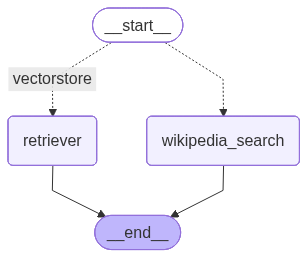

In [174]:
from IPython.display import Image, display
try:
  # Attempts to generate a Mermaid diagram PNG image of the compiled graph. This visualizes the workflow's nodes and edges.
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  # Catches any exceptions that might occur during the graph visualization process (e.g., if external tools are missing or mermaid rendering fails).
  print(e) # Prints the error message, indicating that the visualization failed.

In [175]:
import uuid

user_input = "Hi there! What's agent?" # Defines the user's initial question for the graph.
initial_input = {"question": user_input} # Structures the user input into the dictionary format expected by the graph's initial state.

# Generates a unique thread ID for a clean run. This is crucial for Langgraph's checkpointer
# to maintain separate states for different conversations or runs, ensuring no state leakage.
unique_thread_id = str(uuid.uuid4())

# Invokes the compiled graph with the initial question.
# `invoke()` runs the graph synchronously to completion.
# The `config` parameter is used to pass configurable options to the graph, including the `thread_id`
# which is used by the `MemorySaver` for state management.
final_state = graph.invoke(
    initial_input,
    config={"configurable": {"thread_id": unique_thread_id}}
)

print("\n--- Final State (via Invoke) ---")
# Directly prints the final state dictionary, which contains the processed question, retrieved documents, and any generated content after the graph's execution.
print(final_state)

---- ROUTE QUESTION---
DEBUG: Raw LLM output (source.datasource): 'vectorstore'
DEBUG: Lowercased datasource for routing: 'vectorstore'
---ROUTE QUESTION TO VECTORSTORE
DEBUG: Route function returning: 'vectorstore'
---- Retriever---



--- Final State (via Invoke) ---
{'question': "Hi there! What's agent?", 'documents': [Document(id='ddf2c857128f4691a0d96e8484cb8ddc', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of fi

In [178]:
while True:
  user_input=input("User: ")
  if user_input.lower() in ("quit","q"):
    print("Good Bye")
    break
  # Correct the input to graph.stream to match the GraphState schema
  for event in graph.stream(
      {'question': user_input},
      config={"configurable": {"thread_id": unique_thread_id}}
      ):
    # Langgraph stream yields updates to the state from each node.
    # The 'event' dictionary will have keys corresponding to the nodes that produced output.
    # Each value in event.values() will be a dict like {'documents': [...], 'question': '...'}
    for value in event.values():
      if 'documents' in value:
          print('Assistant (retrieved documents):')
          for doc in value['documents']:
              if hasattr(doc, 'metadata'): # Check if it's a Document object
                  print(f"  - Source: {doc.metadata.get('source', 'N/A')}")
                  print(f"    Content: {doc.page_content[:200]}...") # Truncate content for readability
              else: # Assume it's a plain string from Wikipedia
                  print(f"  - Content: {str(doc)[:200]}...")
      elif 'generation' in value and value['generation']:
          print('Assistant (generated response):')
          print(value['generation'])
      # Optionally, print the current question in the state if it was updated by a node
      if 'question' in value and 'documents' not in value and 'generation' not in value:
          # Avoid re-printing question if documents are also being printed (as they include question)
          print(f"Assistant (processed question): {value['question']}")

User: Hi
---- ROUTE QUESTION---
DEBUG: Raw LLM output (source.datasource): 'wikipedia_search'
DEBUG: Lowercased datasource for routing: 'wikipedia_search'
---ROUTE QUESTION TO WIKI SEARCH
DEBUG: Route function returning: 'wikipedia_search'
---- Wikipedia---
Hi


/usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Assistant (retrieved documents):
  - Content: No good Wikipedia Search Result was found...
User: what is the future of gen Ai
---- ROUTE QUESTION---
DEBUG: Raw LLM output (source.datasource): 'vectorstore'
DEBUG: Lowercased datasource for routing: 'vectorstore'
---ROUTE QUESTION TO VECTORSTORE
DEBUG: Route function returning: 'vectorstore'
---- Retriever---


Assistant (retrieved documents):
  - Source: https://lilianweng.github.io/posts/2023-06-23-agent/
    Content: LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      LLM Powered Autonomous Agen...
  - Source: https://lilianweng.github.io/posts/2023-06-23-agent/
    Content: LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      LLM Powered Autonomous Agen...
  - Source: https://lilianweng.github.io/posts/2023-06-23-agent/
    Content: LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      LLM Powered Autonomous Agen...
  - Source: https://lilianweng.github.io/posts/2023-06-23-agent/
    Content: LLM Powered Autonomous Agents | Lil'Log



